深層学習特論レポート

氏名: Muhammad Harry Bintang Pratama   
学生番号: 20676127


paper with codeの分類: Time-Series  
論文のURL: https://arxiv.org/pdf/1602.04105v3.pdf  
githubのURL: https://github.com/rowantahseen/Modulation-Classification  
deep learning libraryの枠組み: tensorflow backend with keras


In the referenced github repository, there are two model architectures, fisrt is Full Connected Neural Network and the second one is CNN (Convolutional Neural Network). This report only implements the CNN, since this architecture is also used in the referenced paper.

# Preparing the Dataset

The datasets that will be used for radio signal modulation recognition are available online from https://www.deepsig.ai/datasets. The referenced github repo use version RML2016.10b. The dataset that I used is this version: RadioML 2016.04C.  It is different with the dataset that was used in github reference. It contains smaller datapoints.

In [19]:
from sklearn.preprocessing import LabelBinarizer as LB
from sklearn.preprocessing import normalize 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# --------------------
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.core import Reshape, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras import metrics
# --------------------
from pandas import DataFrame as df
# --------------------
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
# --------------------
import tarfile
import pickle
import random
import keras
import sys
import gc


# Found a problem in the original code, could not use it as it is. Must add several line of codes as shown below
# Problem: AttributeError: module 'tensorflow_core._api.v2.config' has no attribute 'experimental_list_devices' when creating 'Sequential' model.
# Solution : Make an injection to keras tensorflow backend until updates comes from keras team

import keras.backend.tensorflow_backend as tfback
print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


['/device:GPU:0']

In [20]:
# Download the dataset and extract it
!wget http://opendata.deepsig.io/datasets/2016.04/2016.04C.multisnr.tar.bz2?__hstc=24938661.44667ce5ff5d5c9e72cdf3cb09da5eff.1593432995007.1593443292009.1595468326005.3&__hssc=24938661.1.1595468326005&__hsfp=3342595576
!tar jxf /content/2016.04C.multisnr.tar.bz2?__hstc=24938661.44667ce5ff5d5c9e72cdf3cb09da5eff.1593432995007.1593443292009.1595468326005.3


--2020-07-23 22:07:17--  http://opendata.deepsig.io/datasets/2016.04/2016.04C.multisnr.tar.bz2?__hstc=24938661.44667ce5ff5d5c9e72cdf3cb09da5eff.1593432995007.1593443292009.1595468326005.3
Resolving opendata.deepsig.io (opendata.deepsig.io)... 52.14.91.165
Connecting to opendata.deepsig.io (opendata.deepsig.io)|52.14.91.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111453168 (106M) [application/x-bzip2]
Saving to: ‘2016.04C.multisnr.tar.bz2?__hstc=24938661.44667ce5ff5d5c9e72cdf3cb09da5eff.1593432995007.1593443292009.1595468326005.3.1’

2016.04C.multisnr.t 100%[===================>] 106.29M  9.20MB/s    in 18s     

2020-07-23 22:07:35 (5.77 MB/s) - ‘2016.04C.multisnr.tar.bz2?__hstc=24938661.44667ce5ff5d5c9e72cdf3cb09da5eff.1593432995007.1593443292009.1595468326005.3.1’ saved [111453168/111453168]



In [21]:
# Load the extracted dataset 

file = open('/content/2016.04C.multisnr.pkl','rb')
Xd = pickle.load(file, encoding='latin')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()

In [22]:
# Create features space: Raw Time Feature, First derivative in time, and integral in time
# Then create a function to put all features together

features = {}
features['raw']        = X[:,0], X[:,1]
features['derivative'] = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))
features['integral']   = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))

def extract_features(*arguments):
    
    desired = ()            
    for arg in arguments:
        desired += features[arg]
    
    return np.stack(desired, axis = 1)

# Split the training and test data

At this part, the dataset set will be splitted into training and test data. In the paper, there is no information derivatice or integral features. Choosing raw feature will use the dataset as it is. Then, the datapoints are randomly shuffled using np.random.choice. Next, split the dataset into 2 with the same size (50% for training data and 50% for test data). I did not now the reason, since this is also different with the referenced paper (60% for training data and 40% for test data). 


In [23]:
# Choose the feature that want to be used

data = extract_features('raw')
labels = np.array(lbl)

in_shape = data[0].shape
out_shape = tuple([1]) + in_shape

In [24]:
# Data shuffling & splitting

np.random.seed(10)

n_examples = labels.shape[0]
print("Number of datapoints:", n_examples)

r = np.random.choice(range(n_examples), n_examples, replace = False)
train_examples = r[:n_examples//2]
test_examples =  r[n_examples//2:]

X_train = data[train_examples]
X_test = data[test_examples]

y_train = LB().fit_transform(labels[train_examples][:,0])
y_test = LB().fit_transform(labels[test_examples][:,0])

snr_train = labels[train_examples][:,1].astype(int)
snr_test = labels[test_examples][:,1].astype(int)

# Check the dataset that will be used: 


print("Number of training data: ",X_train.shape)
print("Number of test data: ",X_test.shape)
print("Number of training labels: ",y_train.shape)
print("Number of test labels: ",y_test.shape)


Number of datapoints: 162060
Number of training data:  (81030, 2, 128)
Number of test data:  (81030, 2, 128)
Number of training labels:  (81030, 11)
Number of test labels:  (81030, 11)


# **Create Model**

This is the most important part, we need to construct a model first before we set it to learn. The model is costructed using sequential model. Since 1) there is no multiple input/output, 2) there is no layer sharing, and 3) non-linear topology is needed, we can go with this kind  of model. Here's a short explanation on each layer:  

1. Input: Reshape the input from [N,2,128] to [N,1,2,128], where N is samples/ batch size. At a time, 1 matrix with size  2 x 128 will enter the network.  

2. Conv/ReLu layers: There 2 layers that use convolution with ReLu as activation function. Both layers are preceded by zero padding with symmetric width pad (each row of input, at the initial and end are appended with 0). channels_first is used for ordering the dimensions in the inputs (batch_size, channels, height, width). The first Conv/ReLU layer has number of output filters 256 and filter size 1 x 3, while the second Conv/ReLU layer has number of output filters 80 and filter size 2 x 3. Both layers are ended with dropout for regularization.  

3. Dense layers: The first dense layer, after the input is flattened, get its output by taking the dot product between input tensor and 256 kernels matrix, and then use ReLU. The second dense layer, get its output by taking the dot product between input tensor and 11 kernels matrix, and then softmax as activation function, since at this stage we want to classify what kind of signal that is being recognized. The output here is 11 classes, corresponding to 11 types of different signals in our dataset.

In [25]:
# Build CNN model
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization
#  - dropout rate 0.5


dr = 0.5
model = Sequential()
model.add(Reshape(out_shape, input_shape = in_shape))

model.add(ZeroPadding2D((0, 2), data_format = 'channels_first'))
model.add(Conv2D(256, (1, 3), padding = 'valid', activation = "relu", name="conv1", kernel_initializer='glorot_uniform', data_format="channels_first"))
model.add(Dropout(dr))

model.add(ZeroPadding2D((0,2), data_format = 'channels_first'))
model.add(Conv2D(80, (2, 3), activation="relu", name="conv3", padding="valid", kernel_initializer="glorot_uniform", data_format="channels_first"))
model.add(Dropout(dr))

model.add(Flatten())   
model.add(Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal"))
model.add(Dropout(dr))

model.add(Dense(11, name="dense3", kernel_initializer="he_normal", activation = 'softmax'))
model.add(Reshape([len(mods)]))




# Training

Before we set the model to train, first we need to configures the model. Here, 3 important parameters are explained. Since this is multi-class classification tasks, for the loss function categorical_crossentropy is used. 'adam' is used as optimizer. 'accuracy' metric is ususally used for classification tasks. This metric calculates how often predictions matches one-hot labels. Metric values are recorded at the end of each epoch on the training/evaluation dataset.

A table that summarizes the network is printed. We can confirm the output shape of each layer type.





In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256, 2, 130)       0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 256, 2, 134)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 80, 1, 132)        122960    
_________________________________________________________________
dropout_5 (Dropout)          (None, 80, 1, 132)       

Now we are ready to train the model with the dataset by calling fit method. The model will be trained with a fixed number of epochs and batch size. Here, the input data is X_train and the corresponding target data is Y_train.The validation_split, which is a fraction of the training data to be used as validation data is set to 0.05. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. Callbacks with EarlyStopping class that will stop training when a monitored metric has stopped improving is used. There is no monitored metric here, but with patience equals 15, if there is no improvement after 15 epochs the training will be stopped. The model weight will be restored from the epoch with the best value. 

Finally save the model. the saved model will includes the model architecture, the model weights, and the state of the optimizer.


In [27]:
model.fit(X_train, y_train, epochs = 80, batch_size = 1024, validation_split = 0.05, callbacks=[EarlyStopping(patience = 15, restore_best_weights = True)])

Train on 76978 samples, validate on 4052 samples
Epoch 1/80
76978/76978 [==============================] - 4s 58us/step - loss: 2.4372 - accuracy: 0.1655 - val_loss: 2.0823 - val_accuracy: 0.2769
Epoch 2/80
76978/76978 [==============================] - 4s 55us/step - loss: 1.8940 - accuracy: 0.3258 - val_loss: 1.6337 - val_accuracy: 0.4247
Epoch 3/80
76978/76978 [==============================] - 4s 55us/step - loss: 1.5765 - accuracy: 0.4159 - val_loss: 1.4002 - val_accuracy: 0.4721
Epoch 4/80
76978/76978 [==============================] - 4s 55us/step - loss: 1.4415 - accuracy: 0.4537 - val_loss: 1.3201 - val_accuracy: 0.5032
Epoch 5/80
76978/76978 [==============================] - 4s 55us/step - loss: 1.3780 - accuracy: 0.4749 - val_loss: 1.2729 - val_accuracy: 0.5220
Epoch 6/80
76978/76978 [==============================] - 4s 55us/step - loss: 1.3281 - accuracy: 0.4941 - val_loss: 1.2349 - val_accuracy: 0.5424
Epoch 7/80
76978/76978 [==============================] - 4s 55us/ste

In [28]:
model.save("cnn.h5")

# Evaluation

Create 3 functions that will be used later.

1. print_results: This function will print a table that shows the accuracy across different SNR (Signal-to-Noise Ratio). First, predicted_labels are calculated from output predictions for the given input samples, which is X_test in this case. Then, the predicted_labels are compared with the true_labels, and get their accuracy score for one SNR. Do the same things with different SNR.  

2. plot_confusion_matrix: Confusion matrix can be used to evaluate the quality of the output of a classifier. The diagonal elements are part of datapoints for which the predicted_labels is equal to the true_labels, while off-diagonal elements are those that are mislabeled by the classifier. Higher number or more bold color at the diagonal elements mean the classifier works as intended.   

3. plot_results: This is the same thing as print_results, but this function will plot as line instead of just print a table.

In [29]:
def print_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

In [30]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
  y_true, y_pred = np.argmax(y_true, axis = 1), np.argmax(y_pred, axis = 1)
  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title = 'Confusion Matrix',
         ylabel = 'True label',
         xlabel = 'Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

In [31]:
def plot_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)


In [32]:
cnn_model = keras.models.load_model('cnn.h5')

In [33]:
y_pred_cnn = model.predict(X_test)

In [34]:
print_results(y_pred_cnn, y_test, snr_test)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,15.25,15.24,15.01,17.55,19.62,26.95,47.16,62.97,74.56,88.92,90.31,91.59,91.56,95.63,88.4,91.52,96.22,90.32,92.84,92.97


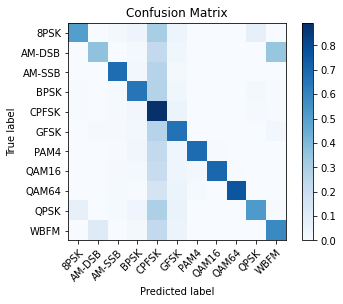

In [35]:
plot_confusion_matrix(y_test, y_pred_cnn, mods)

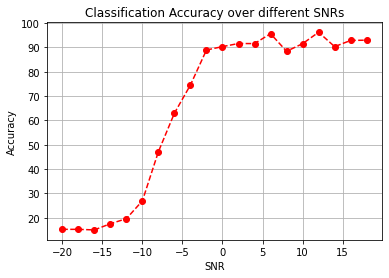

In [36]:
plot_results(y_pred_cnn, y_test, snr_test)